In [3]:
# import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# import constants from dataset_utils.py
from dataset_utils import EXTRACTED_IMAGES_ROOT

# define batch size and image dimensions
batch_size = 32
img_height = 120
img_width = 80


In [4]:
# create train dataset from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    EXTRACTED_IMAGES_ROOT / "TRAIN",  # path to training images
    labels="inferred",  # infer labels from directory structure
    seed=123,  # set random seed for reproducibility
    image_size=(img_height, img_width),  # set image size
    batch_size=batch_size,  # set batch size
    shuffle=True  # shuffle the dataset
)

# create validation dataset from directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    EXTRACTED_IMAGES_ROOT / "VAL",  # path to validation images
    labels="inferred",  # infer labels from directory structure
    seed=123,  # set random seed for reproducibility
    image_size=(img_height, img_width),  # set image size
    batch_size=batch_size,  # set batch size
    shuffle=False  # do not shuffle the dataset
)

# Tune performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)  # cache, shuffle, and prefetch train dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)  # cache and prefetch validation dataset


Found 6602 files belonging to 2 classes.
Found 2146 files belonging to 2 classes.


In [5]:
# define data augmentation pipeline
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),  # randomly flip images horizontally
    layers.RandomRotation(0.1),  # randomly rotate images by 0.1 radians
    layers.RandomZoom(0.1),  # randomly zoom images by 0.1
  ]
)

# define the model architecture
model = Sequential([
    data_augmentation,  # apply data augmentation pipeline to input images
    layers.Rescaling(1./255),  # rescale pixel values to [0,1]
    layers.Conv2D(16, 3, padding='same', activation='relu'),  # apply 16 filters of size 3x3 with ReLU activation
    layers.MaxPooling2D(),  # apply max pooling with default pool size of 2x2
    layers.Conv2D(32, 3, padding='same', activation='relu'),  # apply 32 filters of size 3x3 with ReLU activation
    layers.MaxPooling2D(),  # apply max pooling with default pool size of 2x2
    layers.Conv2D(64, 3, padding='same', activation='relu'),  # apply 64 filters of size 3x3 with ReLU activation
    layers.MaxPooling2D(),  # apply max pooling with default pool size of 2x2
    layers.Dropout(0.2),  # apply dropout with rate of 0.2
    layers.Flatten(),  # flatten the output of the previous layer
    layers.Dense(128, activation='relu'),  # apply a fully connected layer with 128 units and ReLU activation
    layers.Dense(2)  # apply a fully connected layer with 2 units (one for each class)
])

# compile the model
model.compile(optimizer='adam',  # use the Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # use sparse categorical crossentropy loss
              metrics=['accuracy'])  # track accuracy metric during training

# print the model summary
model.summary()  # print a summary of the model architecture


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 120, 80, 3)        0         
                                                                 
 rescaling (Rescaling)       (None, 120, 80, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 120, 80, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 40, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 40, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 20, 32)        0         
 g2D)                                                 

In [6]:
# set the number of epochs to train for
epochs = 100

# train the model on the training dataset and validate on the validation dataset
history = model.fit(
    train_ds,  # use the training dataset
    validation_data=val_ds,  # use the validation dataset
    epochs=epochs  # train for the specified number of epochs
)

Epoch 1/100
207/207 [==============================] - 54s 241ms/step - loss: 0.3164 - accuracy: 0.8643 - val_loss: 0.2482 - val_accuracy: 0.9068
Epoch 2/100
207/207 [==============================] - 40s 193ms/step - loss: 0.2177 - accuracy: 0.9126 - val_loss: 0.1694 - val_accuracy: 0.9390
Epoch 3/100
207/207 [==============================] - 40s 195ms/step - loss: 0.1701 - accuracy: 0.9334 - val_loss: 0.1670 - val_accuracy: 0.9343
Epoch 4/100
207/207 [==============================] - 41s 196ms/step - loss: 0.1731 - accuracy: 0.9352 - val_loss: 0.1423 - val_accuracy: 0.9455
Epoch 5/100
207/207 [==============================] - 41s 198ms/step - loss: 0.1604 - accuracy: 0.9367 - val_loss: 0.1346 - val_accuracy: 0.9478
Epoch 6/100
207/207 [==============================] - 43s 205ms/step - loss: 0.1612 - accuracy: 0.9367 - val_loss: 0.1572 - val_accuracy: 0.9422
Epoch 7/100
207/207 [==============================] - 41s 198ms/step - loss: 0.1371 - accuracy: 0.9500 - val_loss: 0.1048 -

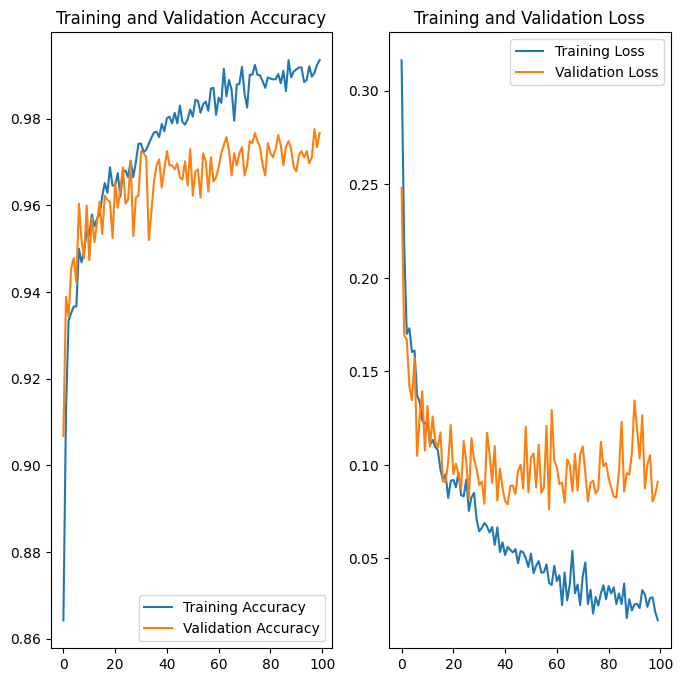

In [7]:
# extract accuracy and loss values from the history object
acc = history.history['accuracy']  # extract training accuracy values
val_acc = history.history['val_accuracy']  # extract validation accuracy values
loss = history.history['loss']  # extract training loss values
val_loss = history.history['val_loss']  # extract validation loss values

# define the range of epochs
epochs_range = range(epochs)

# plot the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')  # plot training accuracy values
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # plot validation accuracy values
plt.legend(loc='lower right')  # add legend to the plot
plt.title('Training and Validation Accuracy')  # add title to the plot

# plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')  # plot training loss values
plt.plot(epochs_range, val_loss, label='Validation Loss')  # plot validation loss values
plt.legend(loc='upper right')  # add legend to the plot
plt.title('Training and Validation Loss')  # add title to the plot
plt.show()  # display the plot


In [8]:
# save the model
model.save("simple_model.keras")

: 